In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.isotonic import IsotonicRegression
from pygam import LogisticGAM, s

In [127]:
input_target = "output/run1/splinePEP/0/peptide.target.txt"
input_decoy = "output/run1/splinePEP/0/peptide.decoy.txt"
columns = ["score", "q-value", "posterior_error_prob"]
df_target = pd.read_csv(input_target, sep="\t", usecols=columns)
df_decoy = pd.read_csv(input_decoy, sep="\t", usecols=columns)
df_target["type"] = int(0)
df_decoy["type"] = int(1)
df = pd.concat([df_target, df_decoy], ignore_index=True)
df = df.sort_values(by='score', ascending=False, ignore_index=True)
df = df.rename(columns={"posterior_error_prob": "pep_percspline"})
x = np.array(range(len(df["score"])))
x_2d = x.reshape(-1, 1)
y = df["type"].values

n_targets = len(df[df["type"] == 0])
n_decoys = len(df[df["type"] == 1])
total = n_targets + n_decoys
prior_decoy = n_decoys / total

In [128]:
iso_reg = IsotonicRegression(y_max=1.0, y_min=0.0, increasing=True, out_of_bounds="clip")
df["pep_isoreg"] = iso_reg.fit_transform(x, y)
df["pep_isoreg"] = np.clip(df["pep_isoreg"] / prior_decoy, 0, 1)
gam = LogisticGAM(s(0, constraints='monotonic_inc')).fit(x_2d, y)
df["pep_logisticgam"] = gam.predict_proba(x_2d)
df["pep_logisticgam"] = np.clip(df["pep_logisticgam"] / prior_decoy, 0, 1)

In [129]:
def estimate_q(df, col):
    df.index += 1
    df[f"q_{col}"] = df[f"pep_{col}"].cumsum() / df.index
    return df
df = df[df["type"] == 0]
df = estimate_q(df, "isoreg")
df = estimate_q(df, "logisticgam")
df = estimate_q(df, "percspline")

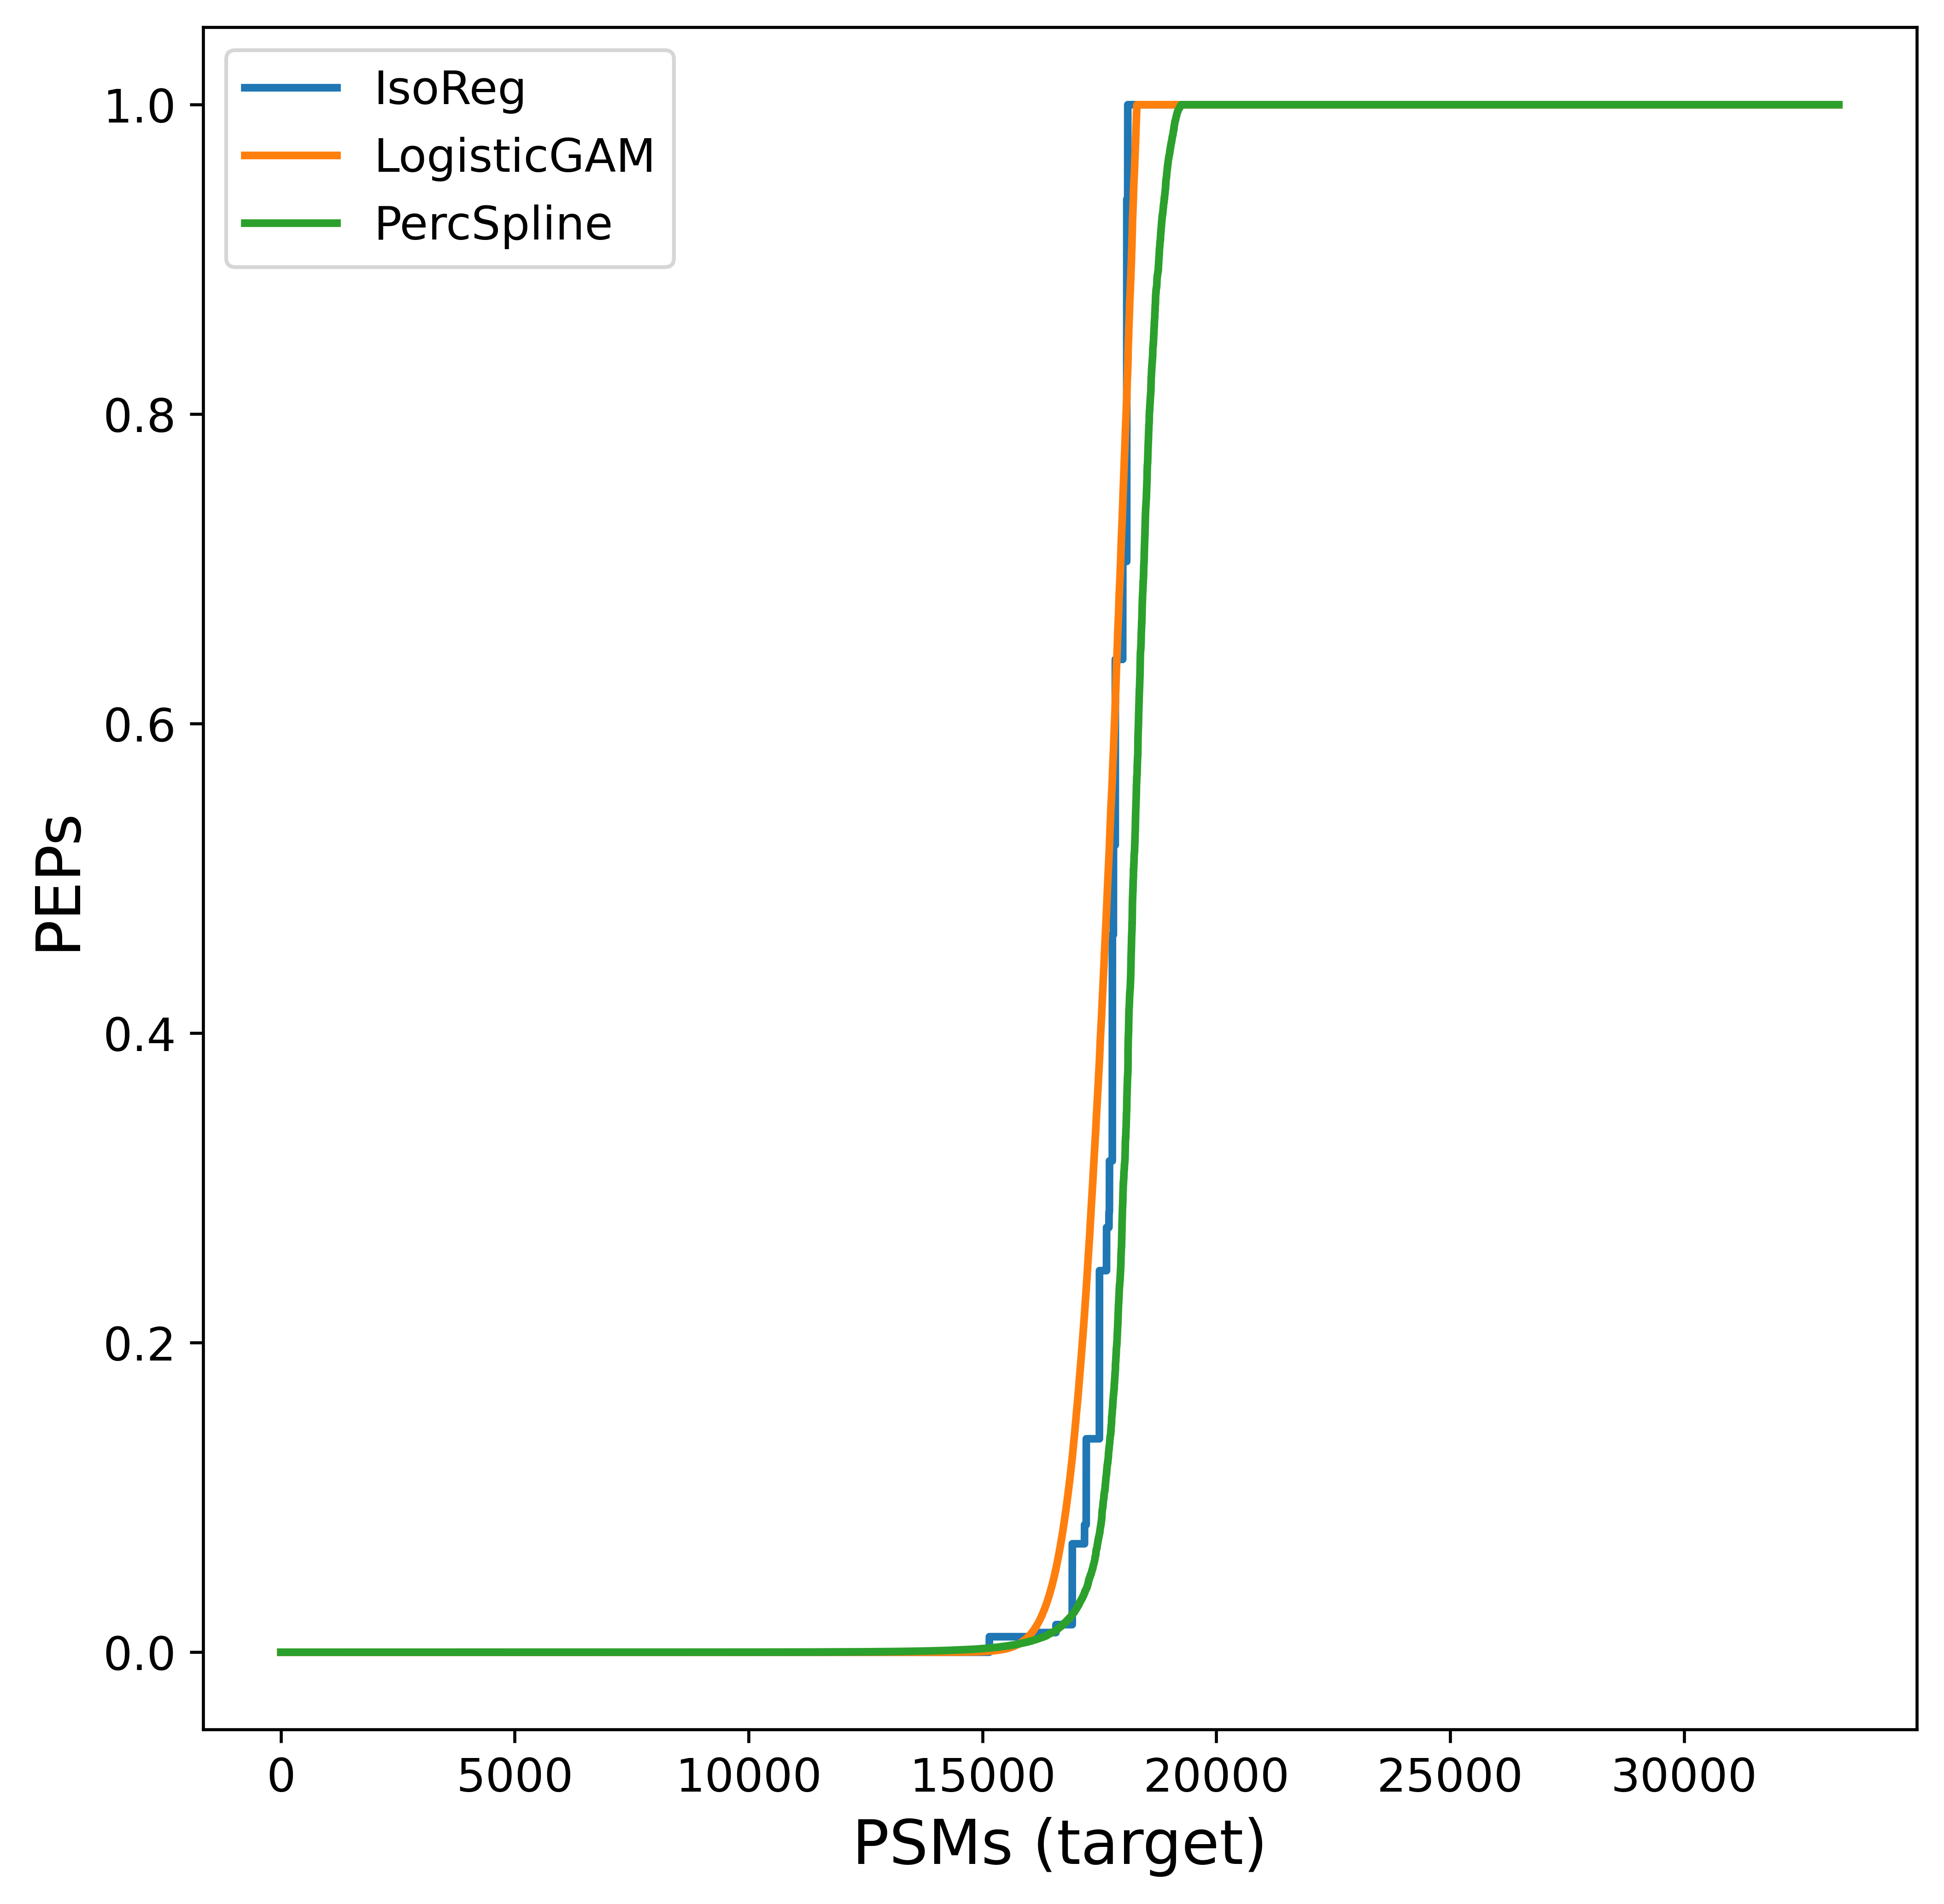

In [131]:
plt.figure(figsize=(8, 8), dpi=600)
x = np.array(range(len(df["score"])))
plt.plot(x, df["pep_isoreg"], label="IsoReg", linewidth=2)
plt.plot(x, df["pep_logisticgam"], label="LogisticGAM", linewidth=2)
plt.plot(x, df["pep_percspline"], label="PercSpline", linewidth=2)
plt.xlabel("PSMs (target)", fontsize=16)
plt.ylabel("PEPs", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

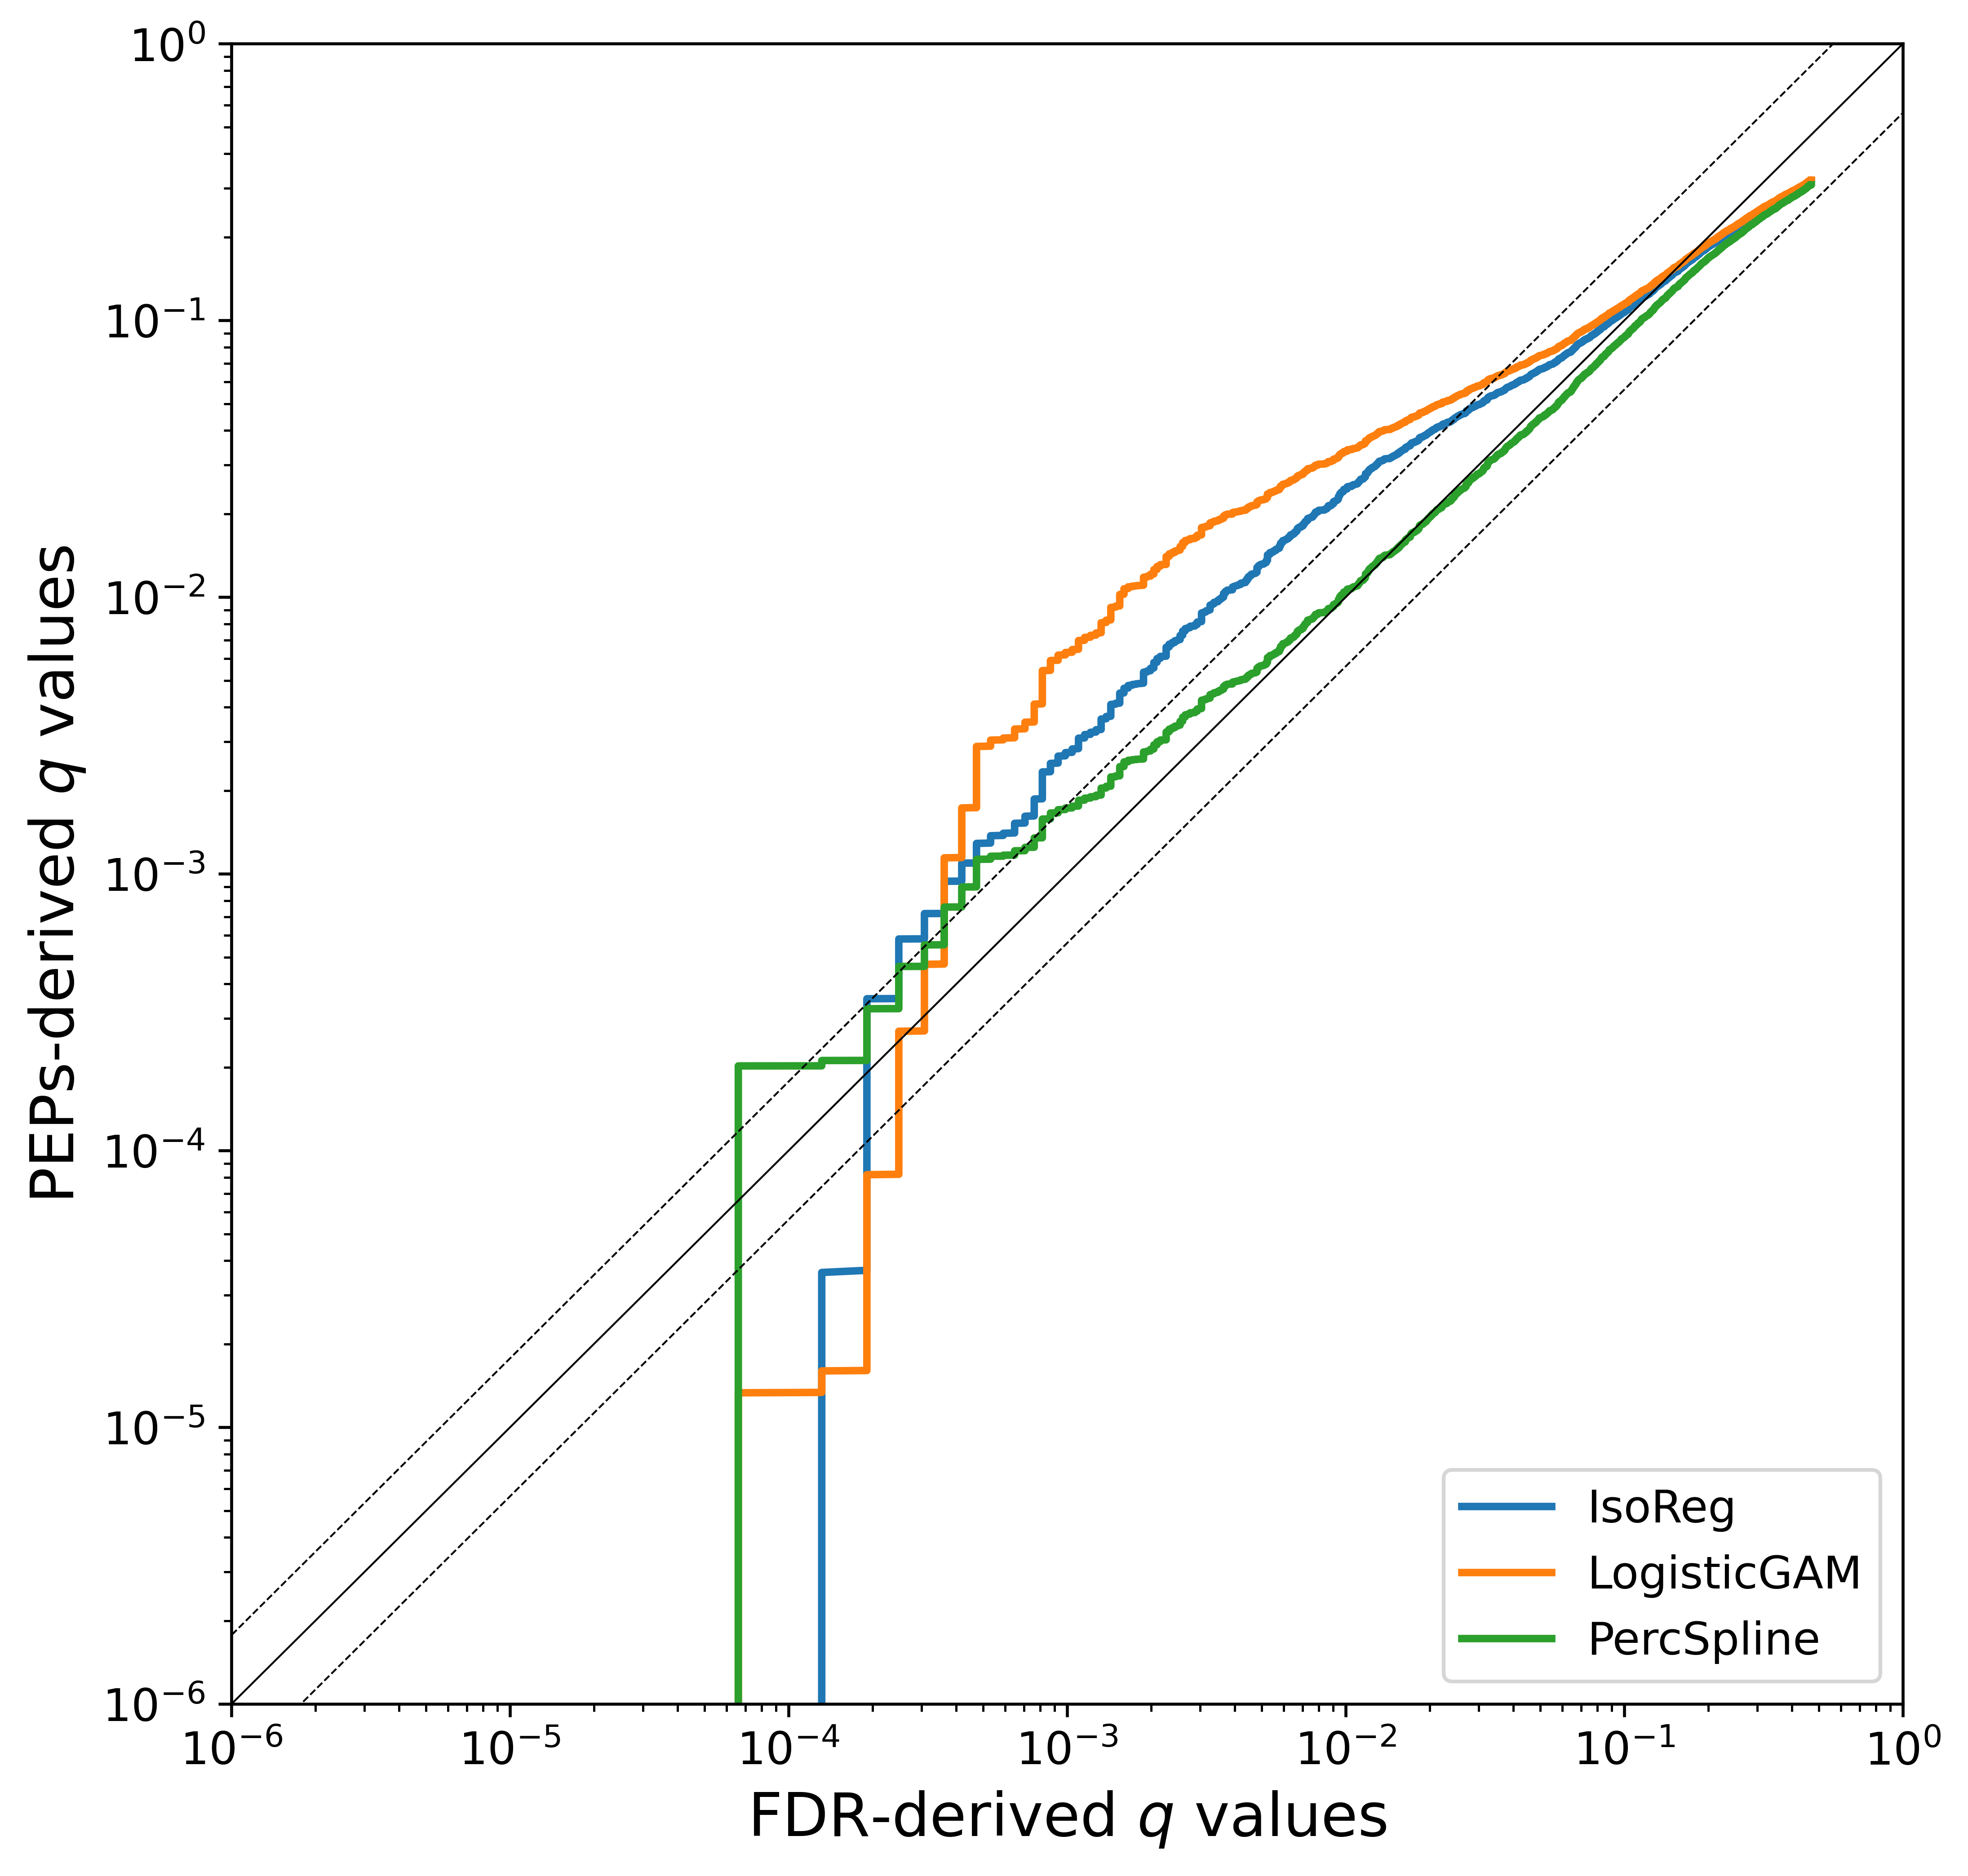

In [132]:
plt.figure(figsize=(8, 8), dpi=600)
plt.plot(df["q-value"], df[f"q_isoreg"], label="IsoReg", linewidth=2)
plt.plot(df["q-value"], df[f"q_logisticgam"], label="LogisticGAM", linewidth=2)
plt.plot(df["q-value"], df[f"q_percspline"], label="PercSpline", linewidth=2)

a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, a, c="k", linewidth=0.5)
plt.xlabel("FDR-derived $q$ values", fontsize=16)
plt.ylabel("PEPs-derived $q$ values", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.000001, 1)
plt.ylim(0.000001, 1)
plt.show()